<img src="kmeans_thumb.jpg" width=70%>

# K-Means Clustering for Embeddings

<h3>Code walk through video <a href="https://www.youtube.com/watch?v=5IA3ChRT90I&list=PLlkpOeXz5iWzqfNyllm5UyOTKpsm1MQbv">K-Means Clustering for Embeddings</a></b></h3>

<b>1. Word embeddings</b>

In [1]:
from sentence_transformers import SentenceTransformer
import warnings
warnings.filterwarnings("ignore")

C:\Users\18623\anaconda3\envs\transformers\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


Pair of words are taken from the <a href="https://huggingface.co/datasets/phi-ai-info/support_tickets">Support Tickets dataset</a> by Phi-Ai.
Full code for Support Tickets Usecase and a way to extract the keywords is explained in <a href="https://github.com/enoten/support_ticket_analysis/blob/main/support_tickets_problem.ipynb">Support Tickets Classification notebook</a>

In [2]:
pairs = ['grant access','revoke access','access profile',
         'add user','delete user','modify user','create user',
         'disk space','disk full', 'disk error']

In [3]:
phrase_model = SentenceTransformer("all-mpnet-base-v2")

In [4]:
embeds = phrase_model.encode(pairs)

In [5]:
embeds.shape

(10, 768)

<b>2. Do dimensionality reduction</b>

In [6]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver='full')
x_embeds = embeds.copy()
X_transformed = pca.fit_transform(embeds)

In [7]:
import numpy as np
centroids = np.random.random((3,2))

In [8]:
scale = 3
centroids = centroids * np.array([[1,scale],[1,scale],[1,scale]])

In [9]:
centroid_dict = {}
for i in range(3):
    centroid_dict[i] = centroids[i,:]
centroid_dict

{0: array([0.84054967, 2.78009568]),
 1: array([0.3457733 , 0.35901205]),
 2: array([0.16549227, 2.62988912])}

In [10]:
centroid_dict = {
    0: np.array([0, 0.4]),
    1: np.array([-0.2, 0.0]),
    2: np.array([0.4, -0.1]),
}

<b>3. Visualize low dim embeddings</b>

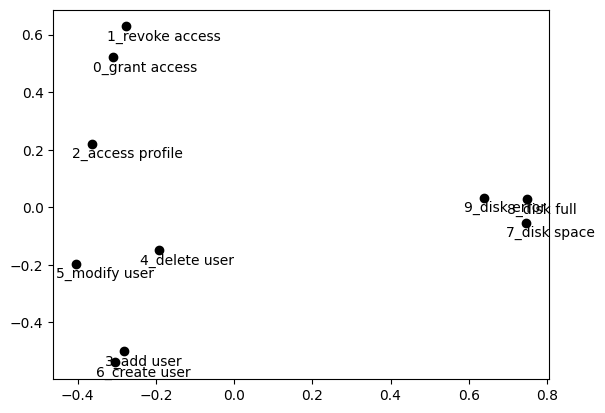

In [11]:
import matplotlib.pyplot as plt
#cent_color = ['red','green','blue']
#for key in centroid_dict.keys():
#    plt.scatter(centroid_dict[key][0],
#                centroid_dict[key][1],
#                color=cent_color[key],marker='x',s=40)
for ind in range(X_transformed.shape[0]):
    plt.scatter(X_transformed[ind,0],
                X_transformed[ind,1],
                marker='o',color='black')
    plt.text(X_transformed[ind,0]-0.05,
                X_transformed[ind,1]-0.05,
                str(ind)+'_'+pairs[ind])

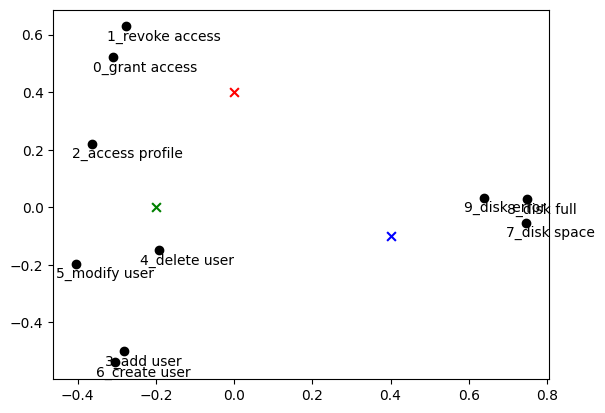

In [12]:
import matplotlib.pyplot as plt
cent_color = ['red','green','blue']
for key in centroid_dict.keys():
    plt.scatter(centroid_dict[key][0],
                centroid_dict[key][1],
                color=cent_color[key],marker='x',s=40)
for ind in range(X_transformed.shape[0]):
    plt.scatter(X_transformed[ind,0],
                X_transformed[ind,1],
                marker='o',color='black')
    plt.text(X_transformed[ind,0]-0.05,
                X_transformed[ind,1]-0.05,
                str(ind)+'_'+pairs[ind])

<b>4. K-means Clustering</b>

<b>4.1 Cluster Assignment Step</b>

In [13]:
import scipy

cluster_dict = {}
for j,data_point in enumerate(X_transformed):
    print(j,' ------ data_point',data_point, f'for pair \"{pairs[j]}\"')
    cent_dist = np.array([])
    for center in centroid_dict.keys():
        print('centroid',center,centroid_dict[center])
        dist = scipy.spatial.distance.euclidean(data_point,centroid_dict[center])
        cent_dist = np.append(cent_dist,dist)
    cent_dist =  np.sqrt(cent_dist)
    print('Distance between data point and ' + ' '.join([f"centroid {i}: {dis}" for i, dis in enumerate(cent_dist)]))
    cluster_index = np.argmin(cent_dist)
    print(f'Min distance is between data point and Cluster {cluster_index}: {cent_dist[cluster_index]}')
    if cluster_index in cluster_dict:
        cluster_dict[cluster_index].append(j)
    else:
        cluster_dict[cluster_index] = [j]
    print()

0  ------ data_point [-0.31082678  0.52309245] for pair "grant access"
centroid 0 [0.  0.4]
centroid 1 [-0.2  0. ]
centroid 2 [ 0.4 -0.1]
Distance between data point and centroid 0: 0.5781978755968228 centroid 1: 0.7312345194783704 centroid 2: 0.9722454891389581
Min distance is between data point and Cluster 0: 0.5781978755968228

1  ------ data_point [-0.2754395   0.62830085] for pair "revoke access"
centroid 0 [0.  0.4]
centroid 1 [-0.2  0. ]
centroid 2 [ 0.4 -0.1]
Distance between data point and centroid 0: 0.5981257205941771 centroid 1: 0.795495829439168 centroid 2: 0.9966432968527198
Min distance is between data point and Cluster 0: 0.5981257205941771

2  ------ data_point [-0.36443973  0.22150323] for pair "access profile"
centroid 0 [0.  0.4]
centroid 1 [-0.2  0. ]
centroid 2 [ 0.4 -0.1]
Distance between data point and centroid 0: 0.6370279796677374 centroid 1: 0.5252330167249677 centroid 2: 0.910657092613057
Min distance is between data point and Cluster 1: 0.5252330167249677



In [14]:
cluster_dict

{0: [0, 1], 1: [2, 3, 4, 5, 6], 2: [7, 8, 9]}

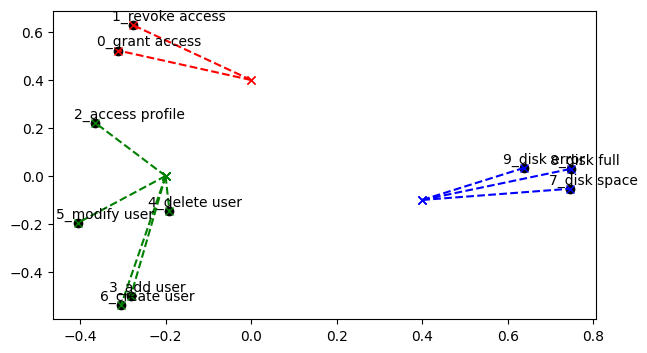

In [15]:
plt.figure(figsize=(7,4))

for i in range(X_transformed.shape[0]):
    plt.scatter(X_transformed[i,0],X_transformed[i,1],marker='o',color="black")
    plt.text(X_transformed[i,0]-0.05,X_transformed[i,1]+0.02, str(i)+"_"+pairs[i])

clust_colors = ['red','green','blue']
for clust_key in cluster_dict.keys():
    cluster_list = cluster_dict[clust_key]
    for item in cluster_list:
        plt.plot([centroid_dict[clust_key][0],X_transformed[item,0]],
                 [centroid_dict[clust_key][1],X_transformed[item,1]],
                 color=clust_colors[clust_key],
                 linestyle='dashed',
                 marker='x')

<b>4.2 Centroid Update Step</b>

In [16]:
centroid_dict_in_time = {}  
centroid_dict_in_time[-1] = centroid_dict.copy() 

centroid_in_time = {key:[centroid_dict[key]] for key in centroid_dict.keys()}

In [17]:
iter_num = 0
for cluster_key in cluster_dict:
    #print()
    cluster_items = cluster_dict[cluster_key]
    cluster_items = np.array(cluster_items).astype(int)
    
    new_centroid = X_transformed[cluster_items].mean(axis=0)

    distance_between_old_new_centroid = scipy.spatial.distance.euclidean(new_centroid,centroid_dict[cluster_key])

    #print(f"old centroid {cluster_key}: {centroid_dict[cluster_key]} new centroid {cluster_key}: {new_centroid}")
    centroid_dict[cluster_key] = new_centroid.copy()
    centroid_in_time[cluster_key].append(new_centroid.copy())
centroid_dict_in_time[iter_num] = centroid_dict.copy()  

Iter num -1
Iter num 0


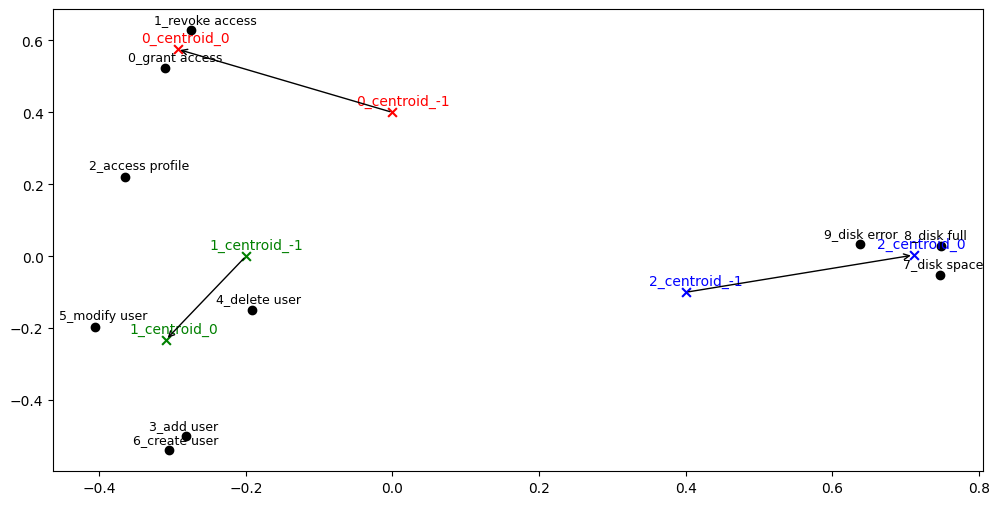

In [20]:
clust_colors = ['red','green','blue']

plt.figure(figsize=(12,6))
for iter_num in range(-1,1):
    print('Iter num',iter_num)
    centroid_dict = centroid_dict_in_time[iter_num]
    for j in centroid_dict.keys():
        plt.scatter(centroid_dict[j][0],
                    centroid_dict[j][1],
                    color=clust_colors[j],marker='x',s=40)
        plt.text(centroid_dict[j][0]-0.05,
                 centroid_dict[j][1]+0.02,
                 str(j)+'_centroid_'+str(iter_num),
                 color=clust_colors[j]
                )
    
for key in centroid_in_time:
    centroid_list = centroid_in_time[key]
    #print(len(centroid_list))
    for i in range(len(centroid_list)-1):
        #print(i)
        plt.annotate('',
                     xy=(centroid_list[i+1][0],centroid_list[i+1][1]),
                     xytext=(centroid_list[i][0],centroid_list[i][1]),
                     arrowprops = dict(arrowstyle='->',color='black')
                    )

for i in range(X_transformed.shape[0]):
    plt.scatter(X_transformed[i,0],X_transformed[i,1],marker='o',color="black")
    plt.text(X_transformed[i,0]-0.05,
             X_transformed[i,1]+0.02, 
             str(i)+"_"+pairs[i],
             fontsize=9
            )

Cluster Assigment Step and Centroid Update Step together constitute a single epoch

<b>4.3 Run multiple epochs</b>

In [21]:
centroid_dict = {
    0: np.array([0, 0.4]),
    1: np.array([-0.2, 0.0]),
    2: np.array([0.4, -0.1]),
}

centroid_in_time = {i:[] for i in range(3)}
for key in centroid_dict:
    centroid_in_time[key].append(centroid_dict[key])

centroid_dict_in_time = {}
centroid_dict_in_time[-1] = centroid_dict.copy()
clusters_in_time = {}


iters = 3
for iter_num in range(iters):
    print(f"------------ Iteration {iter_num} -------------")

    print(">>>>>> Step 1: Assign Data Point to Clusters")
    #Step 1: cluster assigment step
    cluster_dict = {}
    for j,data_point in enumerate(X_transformed):
        #print(j,' ------ data_point',data_point)
        cent_dist = np.array([])
        for center in centroid_dict.keys():
            #print('centroid',center,centroid_dict[center])
            dist = scipy.spatial.distance.euclidean(data_point,centroid_dict[center])
            cent_dist = np.append(cent_dist,dist)
        cent_dist =  np.sqrt(cent_dist)
        #print(cent_dist)
        cluster_index = np.argmin(cent_dist)
        #print('Cluster index',cluster_index)
        if cluster_index in cluster_dict:
            cluster_dict[cluster_index].append(j)
        else:
            cluster_dict[cluster_index] = [j]
            
    clusters_in_time[iter_num] = cluster_dict.copy()

    print(">>>>>> Step 2: Update centroids")
    #Step 2: centroid update step
    for cluster_key in cluster_dict:
        #print()
        cluster_items = cluster_dict[cluster_key]
        cluster_items = np.array(cluster_items).astype(int)
        
        new_centroid = X_transformed[cluster_items].mean(axis=0)
        #print(f"old centroid {cluster_key}: {centroid_dict[cluster_key]} new centroid {cluster_key}: {new_centroid}")
        centroid_dict[cluster_key] = new_centroid.copy()
        centroid_in_time[cluster_key].append(new_centroid.copy())
    centroid_dict_in_time[iter_num] = centroid_dict.copy()

------------ Iteration 0 -------------
>>>>>> Step 1: Assign Data Point to Clusters
>>>>>> Step 2: Update centroids
------------ Iteration 1 -------------
>>>>>> Step 1: Assign Data Point to Clusters
>>>>>> Step 2: Update centroids
------------ Iteration 2 -------------
>>>>>> Step 1: Assign Data Point to Clusters
>>>>>> Step 2: Update centroids


<b>4.4 Resulting clusters</b>

In [22]:
cluster_dict

{0: [0, 1, 2], 1: [3, 4, 5, 6], 2: [7, 8, 9]}

In [23]:
centroid_dict_in_time

{-1: {0: array([0. , 0.4]), 1: array([-0.2,  0. ]), 2: array([ 0.4, -0.1])},
 0: {0: array([-0.29313314,  0.57569665], dtype=float32),
  1: array([-0.30921966, -0.2323269 ], dtype=float32),
  2: array([0.7107882 , 0.00341351], dtype=float32)},
 1: {0: array([-0.316902  ,  0.45763218], dtype=float32),
  1: array([-0.29541463, -0.34578443], dtype=float32),
  2: array([0.7107882 , 0.00341351], dtype=float32)},
 2: {0: array([-0.316902  ,  0.45763218], dtype=float32),
  1: array([-0.29541463, -0.34578443], dtype=float32),
  2: array([0.7107882 , 0.00341351], dtype=float32)}}

In [24]:
centroid_in_time

{0: [array([0. , 0.4]),
  array([-0.29313314,  0.57569665], dtype=float32),
  array([-0.316902  ,  0.45763218], dtype=float32),
  array([-0.316902  ,  0.45763218], dtype=float32)],
 1: [array([-0.2,  0. ]),
  array([-0.30921966, -0.2323269 ], dtype=float32),
  array([-0.29541463, -0.34578443], dtype=float32),
  array([-0.29541463, -0.34578443], dtype=float32)],
 2: [array([ 0.4, -0.1]),
  array([0.7107882 , 0.00341351], dtype=float32),
  array([0.7107882 , 0.00341351], dtype=float32),
  array([0.7107882 , 0.00341351], dtype=float32)]}

In [25]:
clusters_in_time

{0: {0: [0, 1], 1: [2, 3, 4, 5, 6], 2: [7, 8, 9]},
 1: {0: [0, 1, 2], 1: [3, 4, 5, 6], 2: [7, 8, 9]},
 2: {0: [0, 1, 2], 1: [3, 4, 5, 6], 2: [7, 8, 9]}}

<b>4.5 Visualize evolution of centroids across epochs</b>

In [26]:
import random
r = lambda: random.randint(0,255)

def random_color():
    return '#%02X%02X%02X'%(r(),r(),r())

In [27]:
import matplotlib.pyplot as plt

iter_color = ['red','green','blue','cyan']
iter_color = []
for iter_num in range(-1,iters):
    iter_color.append(random_color())
 

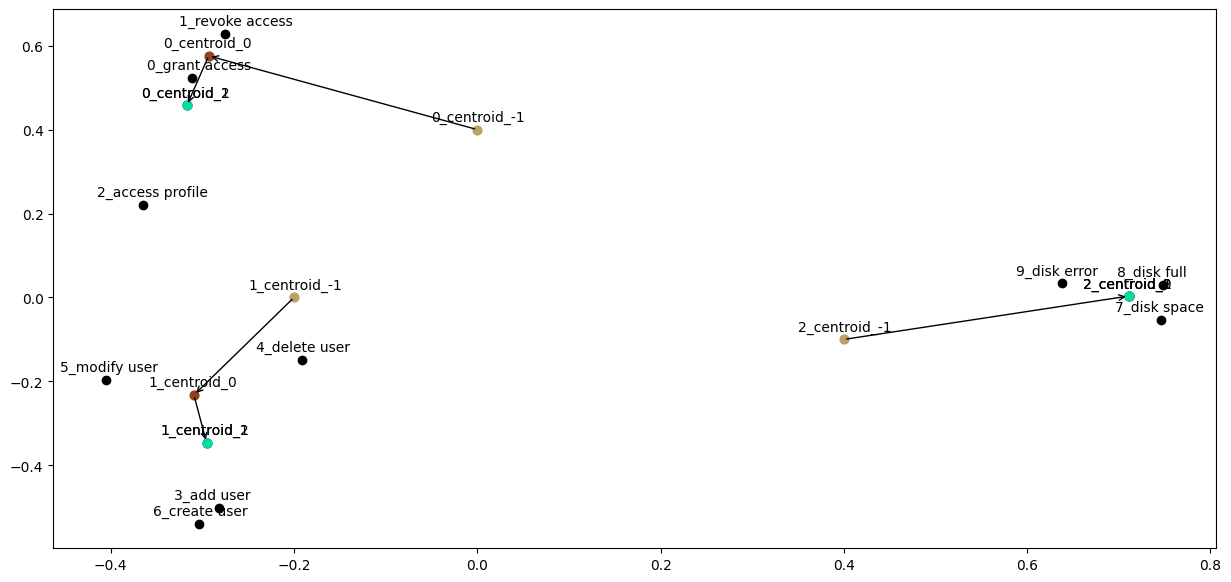

In [28]:
plt.figure(figsize=(15,7))
for iter_num in range(-1,iters):
    #print('Iter num',iter_num)
    centroid_dict = centroid_dict_in_time[iter_num]
    for j in centroid_dict.keys():
        plt.scatter(centroid_dict[j][0],centroid_dict[j][1],color=iter_color[iter_num],marker='o',s=40)
        plt.text(centroid_dict[j][0]-0.05,centroid_dict[j][1]+0.02,str(j)+'_centroid_'+str(iter_num))

for key in centroid_in_time:
    centroid_list = centroid_in_time[key]
    #print(len(centroid_list))
    for i in range(len(centroid_list)-1):
        #print(i)
        plt.annotate('',
                     xy=(centroid_list[i+1][0],centroid_list[i+1][1]),
                     xytext=(centroid_list[i][0],centroid_list[i][1]),
                     arrowprops = dict(arrowstyle='->',color='black')
                    )

for i in range(X_transformed.shape[0]):
    plt.scatter(X_transformed[i,0],X_transformed[i,1],marker='o',color="black")
    plt.text(X_transformed[i,0]-0.05,X_transformed[i,1]+0.02, str(i)+"_"+pairs[i])

<b>4.6 Visualize Clusters</b>

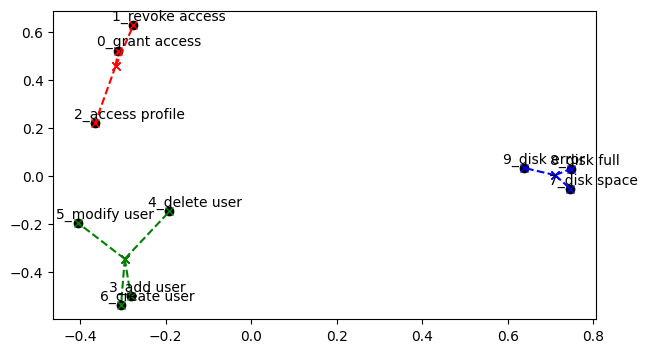

In [29]:
plt.figure(figsize=(7,4))

for i in range(X_transformed.shape[0]):
    plt.scatter(X_transformed[i,0],X_transformed[i,1],marker='o',color="black")
    plt.text(X_transformed[i,0]-0.05,X_transformed[i,1]+0.02, str(i)+"_"+pairs[i])

clust_colors = ['red','green','blue']
for clust_key in cluster_dict.keys():
    cluster_list = cluster_dict[clust_key]
    for item in cluster_list:
        plt.plot([centroid_dict[clust_key][0],X_transformed[item,0]],
                 [centroid_dict[clust_key][1],X_transformed[item,1]],
                 color=clust_colors[clust_key],
                 linestyle='dashed',
                 marker='x')

<b>4.7 Visualize Cluster Size</b>

In [30]:
clust_max_dict = {}
for key in cluster_dict:
    clust_max_dict[key] = 0
    for item in cluster_dict[key]:
        dist = scipy.spatial.distance.euclidean(X_transformed[item],centroid_dict[key])
        #dist = np.sqrt(dist) 
        if dist > clust_max_dict[key]:
            clust_max_dict[key] = dist

In [31]:
clust_max_dict

{0: 0.24086660146713257, 1: 0.22376546263694763, 2: 0.07882901281118393}

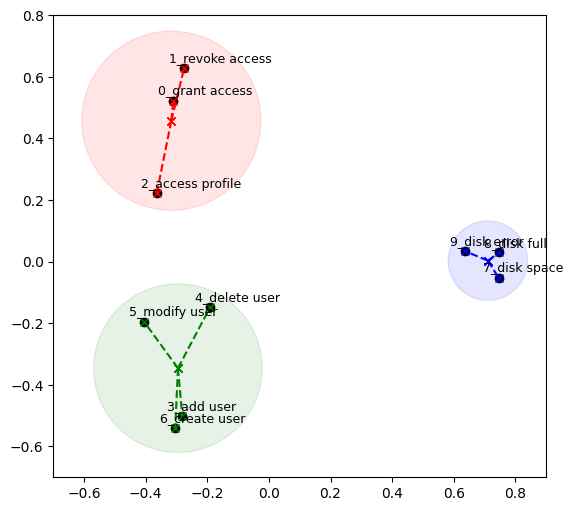

In [32]:
figure, axes = plt.subplots(figsize=(12,6))
#plt.figure()

for i in range(X_transformed.shape[0]):
    plt.scatter(X_transformed[i,0],
                X_transformed[i,1],
                marker='o',
                color="black")
    
    plt.text(X_transformed[i,0]-0.05,
             X_transformed[i,1]+0.02, 
             str(i)+"_"+pairs[i],
             fontsize=9
            )

clust_colors = ['red','green','blue']
for clust_key in cluster_dict.keys():
    cluster_list = cluster_dict[clust_key]
    for item in cluster_list:
        plt.plot([centroid_dict[clust_key][0],X_transformed[item,0]],
                 [centroid_dict[clust_key][1],X_transformed[item,1]],
                 color=clust_colors[clust_key],
                 linestyle='dashed',
                 marker='x')
        
for i,center in enumerate(centroid_dict):
   Drawing_colored_circle = plt.Circle((centroid_dict[center][0],centroid_dict[center][1]), 
                                       clust_max_dict[center]+0.05, 
                                       color=clust_colors[i],
                                       alpha=0.1 )
   axes.set_aspect( 1 )
   axes.add_artist( Drawing_colored_circle )
plt.xlim([-0.7,0.9])
plt.ylim([-0.7,0.8])
#plt.title( 'Colored Circle' )
plt.show() 